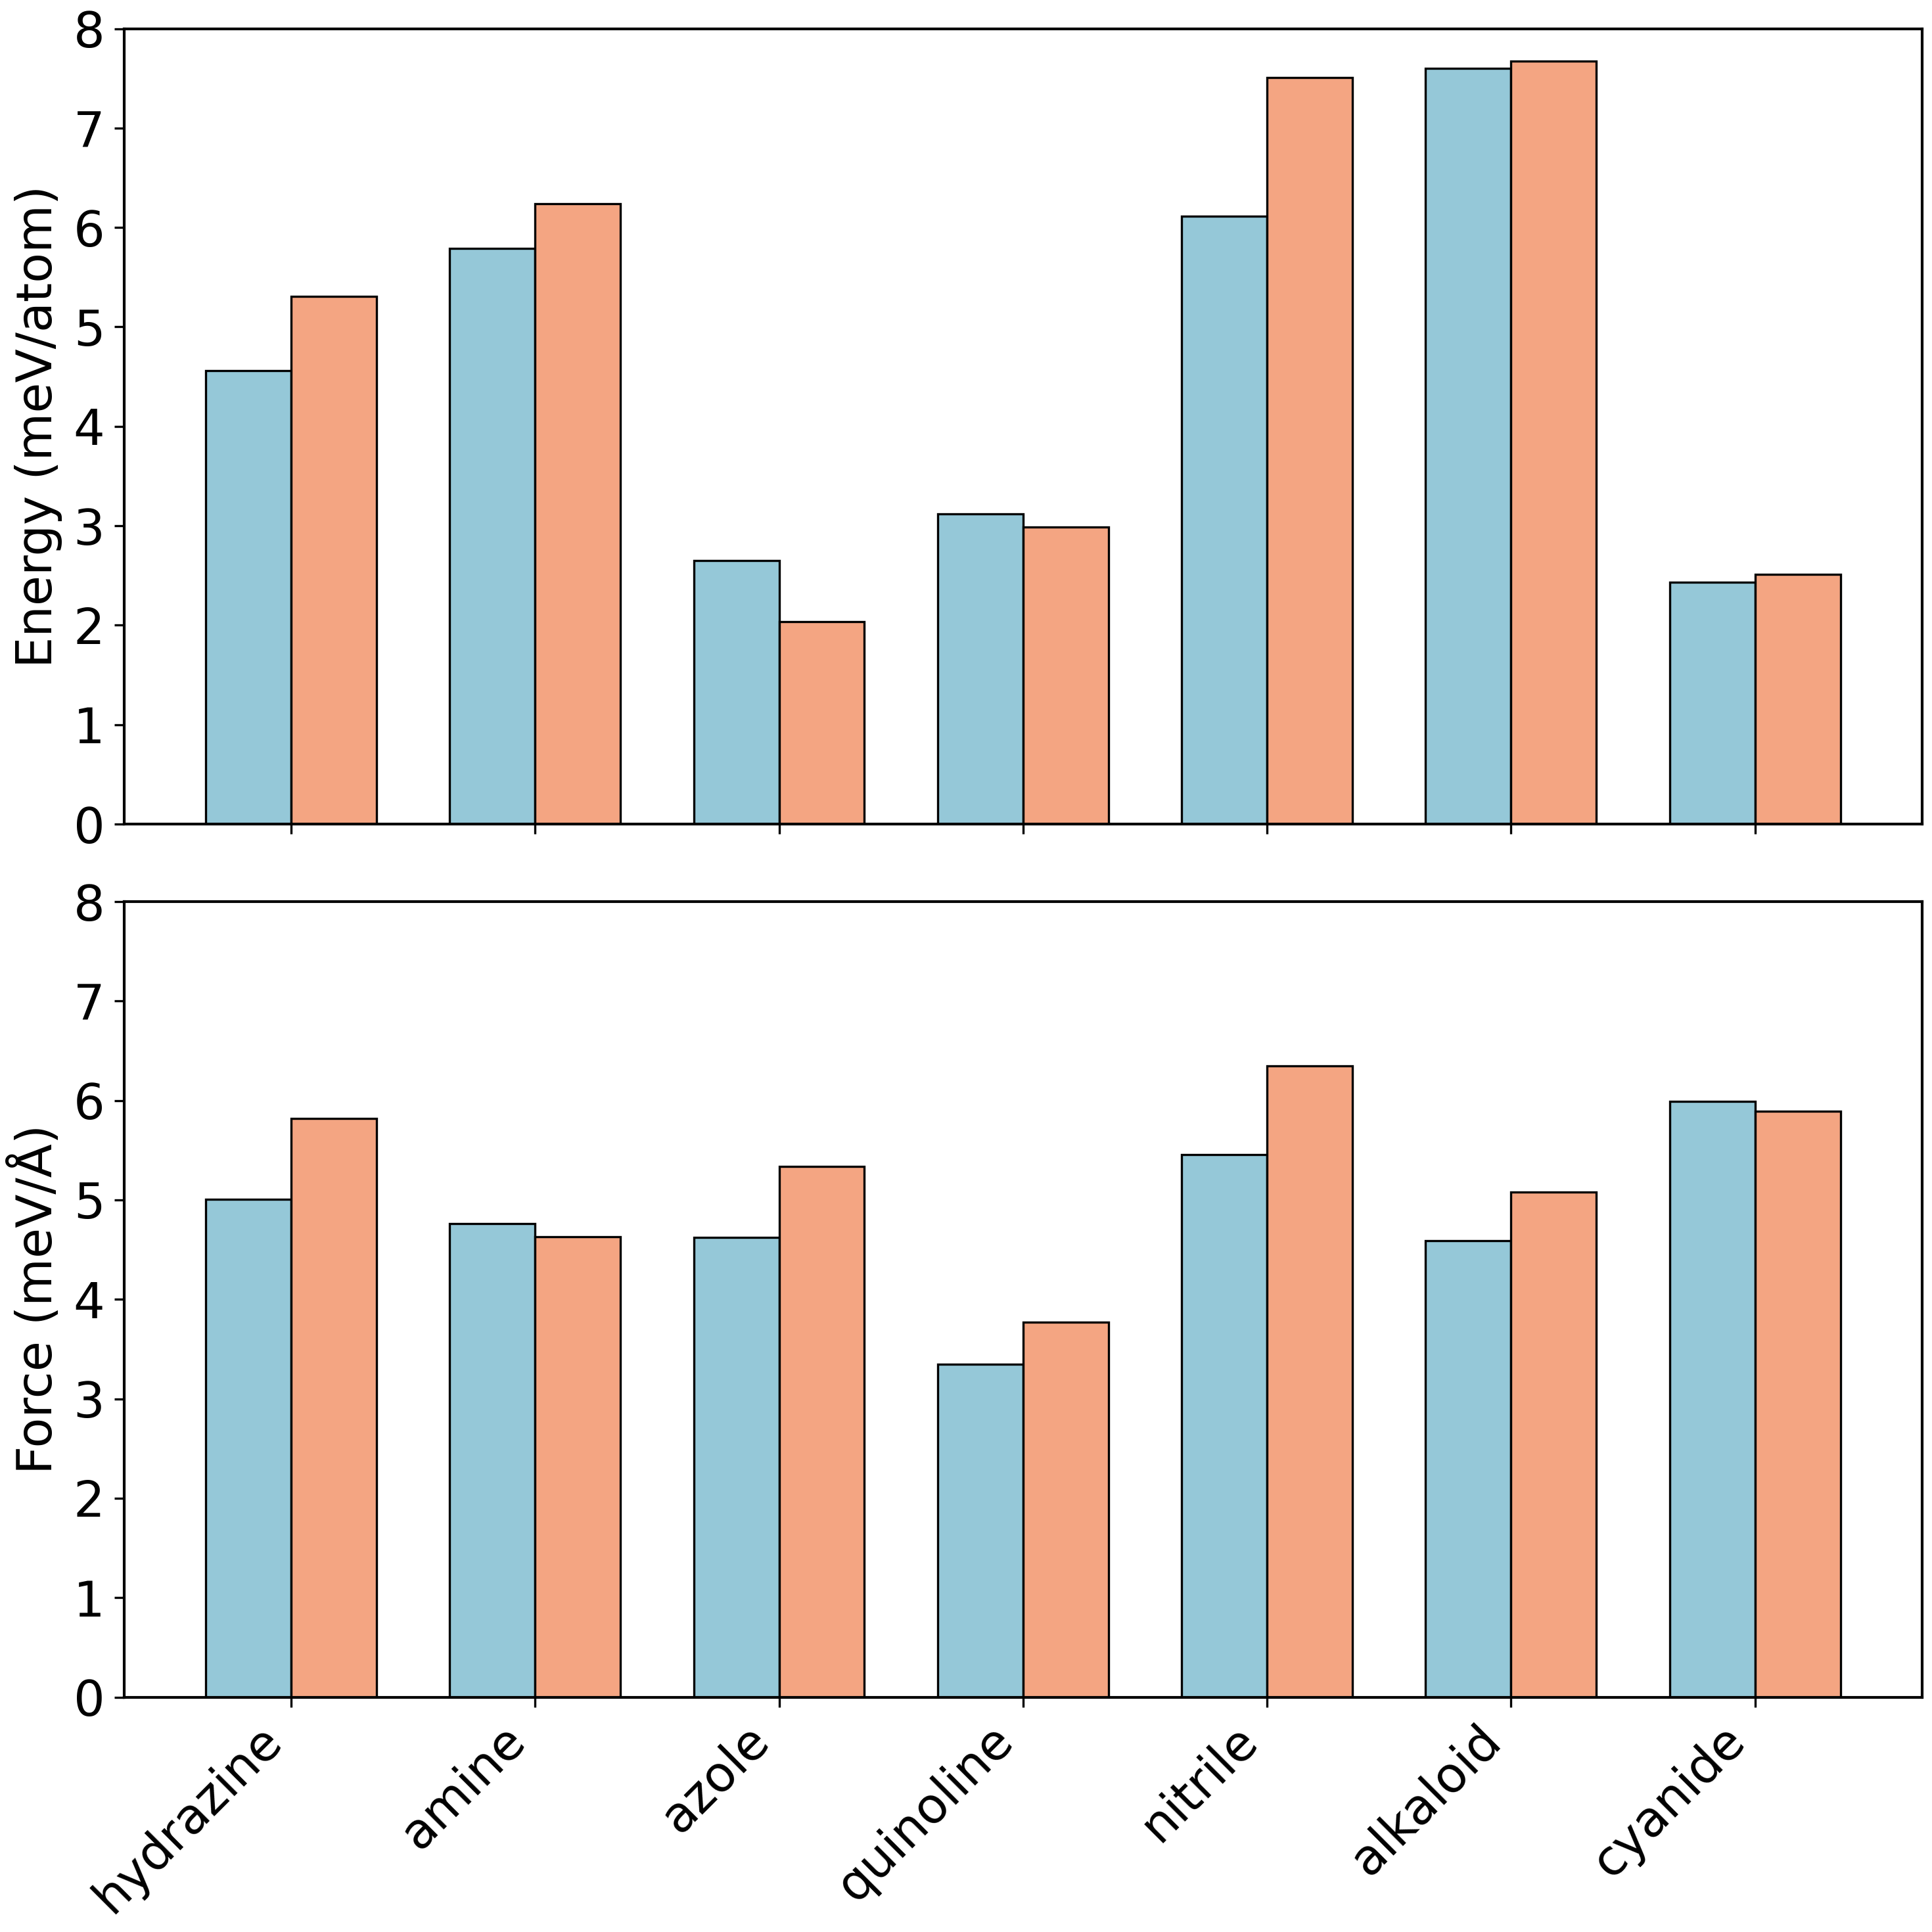

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap

# Nature 스타일의 출판용 그래프 설정
plt.rcParams.update({
    'font.size': 10,
    'axes.linewidth': 1.0,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 600,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.05,
})

# 수정된 경로
current_dir = '../Data/Fig.2/'

subdirectories = [name for name in os.listdir(current_dir) if os.path.isdir(os.path.join(current_dir, name))]

force_mae_values_RBCM = []
potential_mae_values_RBCM = []
force_mae_values = []
potential_mae_values = []
folder_names = []

# 파일에서 MAE 값 읽기 - 수정된 파일 이름
for subdir in subdirectories:
    file_path_RBCM = os.path.join(current_dir, subdir, 'total_mae_BCM.txt')  # _2 제거
    file_path = os.path.join(current_dir, subdir, 'total_mae_SGPR.txt')      # _2 제거
    
    if os.path.exists(file_path_RBCM) and os.path.exists(file_path):
        with open(file_path_RBCM, 'r') as f:
            lines = f.readlines()
            for line in lines:
                if line.startswith('total_force_mae'):
                    total_force_mae_RBCM = float(line.split(':')[1].strip().split()[0])
                elif line.startswith('total_potential_mae'):
                    total_potential_mae_RBCM = float(line.split(':')[1].strip().split()[0])
        with open(file_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                if line.startswith('total_force_mae'):
                    total_force_mae = float(line.split(':')[1].strip().split()[0])
                elif line.startswith('total_potential_mae'):
                    total_potential_mae = float(line.split(':')[1].strip().split()[0])

        force_mae_values_RBCM.append(total_force_mae_RBCM)
        potential_mae_values_RBCM.append(total_potential_mae_RBCM)
        force_mae_values.append(total_force_mae)
        potential_mae_values.append(total_potential_mae)
        folder_names.append(subdir)

# Nature 스타일에 적합한 파스텔 색상 정의
# RBCM용 색상 - 파스텔 블루
rbcm_color = '#95c8d8'  # 파스텔 블루

# SGPR용 색상 - 파스텔 코랄
sgpr_color = '#f4a582'  # 파스텔 코랄/살몬

# 막대 너비와 위치
bar_width = 0.35
n_folders = len(folder_names)
indices = np.arange(len(folder_names))

# 여백이 충분한 더 큰 그림 생성
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
fig.subplots_adjust(hspace=0.3)

# 상단 서브플롯 - 에너지 MAE
ax1.bar(indices - bar_width/2, np.array(potential_mae_values_RBCM) * 1000, bar_width, 
        color=rbcm_color, edgecolor='black', linewidth=0.8)#, label='RBCM')
ax1.bar(indices + bar_width/2, np.array(potential_mae_values) * 1000, bar_width, 
        color=sgpr_color, edgecolor='black', linewidth=0.8)#, label='SGPR')

# 하단 서브플롯 - 힘 MAE
ax2.bar(indices - bar_width/2, np.array(force_mae_values_RBCM) * 1000, bar_width, 
        color=rbcm_color, edgecolor='black', linewidth=0.8)#, label='RBCM')
ax2.bar(indices + bar_width/2, np.array(force_mae_values) * 1000, bar_width, 
        color=sgpr_color, edgecolor='black', linewidth=0.8)#, label='SGPR')

# 축 라벨 및 제목 설정
ax1.set_ylabel('Energy (meV/atom)', fontsize=18)#, fontweight='bold')
ax2.set_ylabel('Force (meV/Å)', fontsize=18)#, fontweight='bold')
# ax1.set_title('Potential Energy MAE Comparison')
# ax2.set_title('Force MAE Comparison')

# X축 라벨 설정 (하단 서브플롯에만)
ax2.set_xticks(indices)
ax2.set_xticklabels(folder_names, rotation=45, ha='right')

# y축 범위 설정 (0에서 8까지)
ax1.set_ylim(0, 8)  # 에너지 MAE
ax2.set_ylim(0, 8)  # 힘 MAE

# 그리드 제거
ax1.grid(False)
ax2.grid(False)

# 배경색 설정 - Nature 논문 스타일의 깨끗한 흰색 배경
ax1.set_facecolor('white')
ax2.set_facecolor('white')
fig.patch.set_facecolor('white')

# 가로선 추가 (미묘한 회색 가로선으로 가독성 향상)
for ax in [ax1, ax2]:
    # y=0 라인을 강조
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

# 축 테두리 조정 - 요청에 따라 모든 축 표시
for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['right'].set_linewidth(1.0)
    ax.spines['top'].set_linewidth(1.0)
    ax.spines['bottom'].set_linewidth(1.0)

# 높은 해상도로 저장
plt.tight_layout()
fig.savefig('Figure2.png', dpi=600)
# fig.savefig('nature_style_mae_comparison.pdf', format='pdf')

plt.show() 